In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import t
import matplotlib.pyplot as plt

In [2]:
## Step 1: Import market index data

market_index = pd.read_excel('C:\\Users\\kissr\\Downloads\\EGYETEM_MSC\\Eseményelemzés\\Tarifs\\msci_world_index.xlsx', index_col='date')
market_index.columns = market_index.columns.str.replace('return', 'market_return')
market_index = market_index[['market_return']]

In [5]:
## Step 2: Import automobile stocks data

automobiles = pd.read_excel('C:\\Users\\kissr\\Downloads\\EGYETEM_MSC\\Eseményelemzés\\Tarifs\\automobiles_all.xlsx', sheet_name='all')
automobiles.dropna(axis=0, inplace=True) # drops every row with NaN values, for example where there is no volume (trading that day)

In [3]:
## Step 3: Generate the event and estimation windows for the events

event_date = pd.to_datetime('2024-11-05') # change (2024-02-05, 2024-11-05, 2024-11-25), 11-26 tariffs were announced after the US stock market close
event_window = pd.to_datetime([event_date + pd.offsets.BusinessDay(day) for day in range(-1,4,1)])
estimation_window = pd.to_datetime([event_date + pd.offsets.BusinessDay(day) for day in range(-486,-235,1)])

length_of_estimation_window = len(estimation_window)
length_of_event_window = len(event_window)

In [6]:
## Step 4: Clean the dataset

#dropping penny stocks
automobiles = automobiles.loc[automobiles['price'] >= 5]

#dropping daily returns higher than 200%
automobiles = automobiles.loc[automobiles['return'] <= 2]

# Group the data by company_name and filter based on the number of observations
automobiles = automobiles.groupby('company_name').filter(lambda x: len(x) >= length_of_estimation_window)

In [7]:
## Step 5: Create the clusters

# Country
asia = automobiles[automobiles['group'] == 'Asia']
usa = automobiles[automobiles['group'] == 'USA']
china = automobiles[automobiles['group'] == 'China']
europe = automobiles[automobiles['group'] == 'Europe']

# Electric or not
electric_asia = automobiles[((automobiles['group'] == 'Asia') | (automobiles['group'] == 'China')) & (automobiles['electric'] == 'Yes')]
electric_rest = automobiles[((automobiles['group'] == 'USA') | (automobiles['group'] == 'Europe')) & (automobiles['electric'] == 'Yes')]
not_electric_asia = automobiles[((automobiles['group'] == 'Asia') | (automobiles['group'] == 'China')) & (automobiles['electric'] == 'No')]
not_electric_rest = automobiles[((automobiles['group'] == 'USA') | (automobiles['group'] == 'Europe')) & (automobiles['electric'] == 'No')]

# US subsidiary

us_subsidiary_asia = automobiles[((automobiles['group'] == 'Asia') | (automobiles['group'] == 'China')) & (automobiles['us_subsidiary'] == 'Yes')]
us_subsidiary_rest = automobiles[((automobiles['group'] == 'USA') | (automobiles['group'] == 'Europe')) & (automobiles['us_subsidiary'] == 'Yes')]
no_us_subsidiary_asia = automobiles[((automobiles['group'] == 'Asia') | (automobiles['group'] == 'China')) & (automobiles['us_subsidiary'] == 'No')]
no_us_subsidiary_rest = automobiles[((automobiles['group'] == 'USA') | (automobiles['group'] == 'Europe')) & (automobiles['us_subsidiary'] == 'No')]

In [8]:
## Step 6: shift the date for Asia and China

# Pivot the datasets
asia_pivot = asia.pivot(index='date', columns='company_name', values='return')
china_pivot = china.pivot(index='date', columns='company_name', values='return')
usa_pivot = usa.pivot(index='date', columns='company_name', values='return')
europe_pivot = europe.pivot(index='date', columns='company_name', values='return')

electric_asia_pivot = electric_asia.pivot(index='date', columns='company_name', values='return')
electric_rest_pivot = electric_rest.pivot(index='date', columns='company_name', values='return')
not_electric_asia_pivot = not_electric_asia.pivot(index='date', columns='company_name', values='return')
not_electric_rest_pivot = not_electric_rest.pivot(index='date', columns='company_name', values='return')

us_subsidiary_asia_pivot = us_subsidiary_asia.pivot(index='date', columns='company_name', values='return')
us_subsidiary_rest_pivot = us_subsidiary_rest.pivot(index='date', columns='company_name', values='return')
no_us_subsidiary_asia_pivot = no_us_subsidiary_asia.pivot(index='date', columns='company_name', values='return')
no_us_subsidiary_rest_pivot = no_us_subsidiary_rest.pivot(index='date', columns='company_name', values='return')

# Fix any potential column name issues
asia_pivot.columns.name = None  # Remove the 'company_name' label from the columns
china_pivot.columns.name = None  
usa_pivot.columns.name = None 
europe_pivot.columns.name = None 

electric_asia_pivot.columns.name = None 
electric_rest_pivot.columns.name = None 
not_electric_asia_pivot.columns.name = None 
not_electric_rest_pivot.columns.name = None 

us_subsidiary_asia_pivot.columns.name = None 
us_subsidiary_rest_pivot.columns.name = None 
no_us_subsidiary_asia_pivot.columns.name = None 
no_us_subsidiary_rest_pivot.columns.name = None 

# Shift the rows for all columns except 'date' by 1 trading day

asia_shifted = asia_pivot.shift(-1)
china_shifted = china_pivot.shift(-1)
electric_asia_shifted = electric_asia_pivot.shift(-1)
not_electric_asia_shifted = not_electric_asia_pivot.shift(-1)
us_subsidiary_asia_shifted = us_subsidiary_asia_pivot.shift(-1)
no_us_subsidiary_asia_shifted = no_us_subsidiary_asia_pivot.shift(-1)

electric = pd.merge(electric_asia_shifted, electric_rest_pivot, on='date', how='left')
not_electric = pd.merge(not_electric_asia_shifted, not_electric_rest_pivot, on='date', how='left')
us_subsidiary = pd.merge(us_subsidiary_asia_shifted, us_subsidiary_rest_pivot, on='date', how='left')
no_us_subsidiary = pd.merge(no_us_subsidiary_asia_shifted, no_us_subsidiary_rest_pivot, on='date', how='left')

In [9]:
## Step 7: Merge each dataset with the market index

# create the dataset that contains every group (with the shifted trading days for Asia and China)

automobiles_all = pd.merge(asia_shifted, china_shifted,on='date', how='left')
automobiles_all = pd.merge(automobiles_all, usa_pivot,on='date', how='left')
automobiles_all = pd.merge(automobiles_all, europe_pivot,on='date', how='left')

# merge with the MSCI index
asia = pd.merge(asia_shifted, market_index, on='date', how='left')
china = pd.merge(china_shifted, market_index, on='date', how='left')
europe = pd.merge(europe_pivot, market_index, on='date', how='left')
usa = pd.merge(usa_pivot, market_index, on='date', how='left')
automobiles_all = pd.merge(automobiles_all, market_index, on='date', how='left')

electric = pd.merge(electric, market_index, on='date', how='left')
not_electric = pd.merge(not_electric, market_index, on='date', how='left')
us_subsidiary = pd.merge(us_subsidiary, market_index, on='date', how='left')
no_us_subsidiary = pd.merge(no_us_subsidiary, market_index, on='date', how='left')

In [10]:
## Step 8: Calculate the AR-s for each company for each day in the event window

# Define market index column (replace 'market_index_column' with the actual column name)
market_index_column = 'market_return'

results = {}

# Loop through each company column
for company in no_us_subsidiary.columns: #change automobile_all, usa, china, asia, europe, electric, not_electric, us_subsidiary, no_us_subsidiary
    if company == market_index_column:  # Skip market index column
        continue

    # Extract returns for the company and the market
    data = automobiles_all[[company, market_index_column]].dropna().copy()
    data.columns = ['company_return', 'market_return']  # Rename columns for clarity
    
    # Find overlapping dates for the estimation and event windows
    estimation_dates = data.index.intersection(estimation_window)
    event_dates = data.index.intersection(event_window)
    
    # Extract data for the estimation and event windows
    estimation_data = data.loc[estimation_dates]
    event_data = data.loc[event_dates]
    
    # Ensure no missing data in the estimation window
    if estimation_data.isnull().any().any() or len(estimation_data) < 2:  # At least two data points are needed
        continue
    
    # OLS regression to calculate expected returns
    model = sm.OLS(estimation_data['company_return'], sm.add_constant(estimation_data['market_return'])).fit()
    
    # Calculate expected returns and abnormal returns for the event window
    event_data['expected_return'] = model.params[0] + model.params[1] * event_data['market_return']
    event_data['AR'] = event_data['company_return'] - event_data['expected_return']
    event_data['CAR'] = event_data['AR'].cumsum()
    
    # Calculate sample variance of abnormal returns in the estimation window
    sample_variance = np.sum((estimation_data['company_return'] - 
                              (model.params[0] + model.params[1] * estimation_data['market_return'])) ** 2) / (length_of_estimation_window - 2)
    
    # Compute AR t-statistics and p-values for the event window
    event_data['AR_t_statistic'] = event_data['AR'] / np.sqrt(sample_variance)
    n = length_of_estimation_window
    K = 2  # Degrees of freedom (parameters in the model)
    df = n - K
    event_data['AR_p_value'] = 2 * (1 - t.cdf(abs(event_data['AR_t_statistic']), df=df))
    

    # Compute CAR t-statistics and p-values for the event window
    event_data['CAR_t_statistic'] = event_data['CAR'] / np.sqrt(np.arange(1, len(event_data) + 1) * sample_variance)
    event_data['CAR_p_value'] = 2 * (1 - t.cdf(abs(event_data['CAR_t_statistic']), df=df))
    
    n = length_of_estimation_window
    K = 2  # Degrees of freedom (parameters in the model)
    df = n - K
    event_data['CAR_p_value'] = 2 * (1 - t.cdf(abs(event_data['CAR_t_statistic']), df=df))
    
    # Store results for this company
    results[company] = event_data[['AR', 'AR_t_statistic', 'AR_p_value', 'CAR', 'CAR_t_statistic', 'CAR_p_value']]

# Combine results into a single DataFrame for easy access
all_results = pd.concat(results, axis=1)

## AAR -  Calculate the average abnormal return (AAR) for each day in the event window

aar = all_results.xs('AR', level=1, axis=1).mean(axis=1)
# Calculate the squared differences from AAR for each day
squared_diff = (all_results.xs('AR', level=1, axis=1).subtract(aar, axis=0))**2
# Calculate the variance of AAR for each day
aar_variance = squared_diff.sum(axis=1) / (len(results) - 1)  # n-1 degrees of freedom
# Calculate the t-statistics for AAR
aar_t_stat = np.sqrt(len(results)) * aar / np.sqrt(aar_variance)
# Degrees of freedom for the t-statistic (n-1, where n is the number of companies)
df_aar = len(results) - 1
# Calculate the p-values for AAR using the t-distribution
aar_p_value = 2 * (1 - t.cdf(abs(aar_t_stat), df=df_aar))
# 95% confidence intervals
aar_upper = aar + t.ppf(0.975, df_aar) * np.sqrt(aar_variance)/np.sqrt(len(results))
aar_lower = aar - t.ppf(0.975, df_aar) * np.sqrt(aar_variance)/np.sqrt(len(results))

## CAAR -  Calculate the cumulative average abnormal return (CAAR) for each day in the event window

caar = all_results.xs('CAR', level=1, axis=1).mean(axis=1)
squared_diff = (all_results.xs('CAR', level=1, axis=1).subtract(caar, axis=0))**2
caar_variance = squared_diff.sum(axis=1) / (len(results) - 1) 
caar_t_stat = np.sqrt(len(results)) * caar / np.sqrt(caar_variance)
df_caar = len(results) - 1
caar_p_value = 2 * (1 - t.cdf(abs(caar_t_stat), df=df_caar))
caar_upper = caar + t.ppf(0.975, df_caar) * np.sqrt(caar_variance)/np.sqrt(len(results))
caar_lower = caar - t.ppf(0.975, df_caar) * np.sqrt(caar_variance)/np.sqrt(len(results))

# Create a DataFrame for AAR and its statistics
aar_results = pd.DataFrame({
    'AR': aar,
    'AR_t_statistic': aar_t_stat,
    'AR_p_value': aar_p_value,
    'aar_upper_bound': aar_upper,
    'aar_lower_bound': aar_lower
})

# Create a DataFrame for CAAR and its statistics
caar_results = pd.DataFrame({
    'CAR': caar,
    'CAR_t_statistic': caar_t_stat,
    'CAR_p_value': caar_p_value,
    'caar_upper_bound': caar_upper,
    'caar_lower_bound': caar_lower
})

# Combine AAR and CAAR into a single DataFrame
average_results = pd.concat([aar_results, caar_results], axis=1)

# Add a new level to the column MultiIndex for "Average"
average_results.columns = pd.MultiIndex.from_product([['average'], average_results.columns])
all_results = pd.concat([all_results, average_results], axis=1)
all_results = all_results.sort_index(axis=1)

In [11]:
# Reformat results
reformatted_results = {}

# Loop through each metric to extract its values for all companies
for metric in ['AR', 'AR_t_statistic', 'AR_p_value', 'CAR', 'CAR_t_statistic', 'CAR_p_value', 'aar_upper_bound', 'aar_lower_bound', 'caar_upper_bound', 'caar_lower_bound']:
    metric_data = all_results.xs(metric, level=1, axis=1).T  # Extract metric and transpose
    metric_data['metric'] = metric  # Add metric name as a column
    reformatted_results[metric] = metric_data.reset_index()  # Reset index for stacking later

# AAR and CAAR
#averages  = all_results.iloc(['AAR', 't_statistic_ARR', 'p_value_AAR', 'CAAR', 't_statistic_CARR', 'p_value_CAAR'])
# Combine all metrics into one DataFrame
combined_results = pd.concat(reformatted_results.values())

# Create a multi-index with 'company' and 'metric'
combined_results.set_index(['index', 'metric'], inplace=True)

# Rename the index for clarity
combined_results.index.names = ['company', 'metric']

# Transpose the DataFrame to make dates columns
final_results = combined_results.T
final_results = final_results.T

# Sort by the 'company' level in the multi-index
final_results = final_results.sort_index(level='company')
final_results.reset_index(inplace=True)
final_results['company'] = final_results['company'].ffill()
final_results = final_results.dropna()

# Multiply AR and CAR rows by 100, better for visualization and rounding
columns_to_modify = final_results.columns[2:]  
final_results.loc[final_results['metric'].isin(['AR', 'CAR', 'aar_upper_bound', 'aar_lower_bound', 'caar_upper_bound', 'caar_lower_bound']), columns_to_modify] *= 100

In [12]:
## Formatting the result tables

# Function to add asterisks based on p-values
def add_asterisks(value, p_value):
    if pd.isna(value) or pd.isna(p_value):
        return value
    elif p_value <= 0.01:
        return f"{value}***"
    elif p_value <= 0.05:
        return f"{value}**"
    elif p_value <= 0.1:
        return f"{value}*"
    else:
        return value

# Process the DataFrame
def process_dataframe(df):
    # Get the list of date columns (skip the first two columns: 'company' and 'metric')
    date_columns = df.columns[2:]

    # Reformat date columns to 'YYYY-MM-DD' format
    new_date_columns = pd.to_datetime(date_columns).strftime('%Y-%m-%d')
    df.rename(columns=dict(zip(date_columns, new_date_columns)), inplace=True)

    # Update the list of date columns after renaming
    date_columns = new_date_columns

    # Round all values in date columns to 2 decimals
    df[date_columns] = df[date_columns].round(2)

    # Iterate over the AR and CAR rows
    for metric in ['AR', 'CAR']:
        # Get the corresponding p-value rows
        p_value_metric = f"{metric}_p_value"

        # Loop through each date column to modify AR and CAR rows
        for date in date_columns:
            # Apply the asterisks function for this date
            df.loc[df['metric'] == metric, date] = df.loc[df['metric'] == metric].apply(
                lambda row: add_asterisks(row[date], 
                                          df.loc[(df['company'] == row['company']) & (df['metric'] == p_value_metric), date].values[0]),
                axis=1
            )
    return df

# Assuming your DataFrame is called `final_results`
final_results = process_dataframe(final_results)
final_results = final_results[final_results['metric'].isin(['AR', 'CAR', 'aar_upper_bound', 'aar_lower_bound', 'caar_upper_bound', 'caar_lower_bound'])]
final_results.set_index('company', inplace=True)

In [162]:
file_path = 'C:\\Users\\kissr\\Downloads\\\\EGYETEM_MSC\\Eseményelemzés\\Tarifs\\resulttables1.xlsx' 
final_results.to_excel(file_path, sheet_name='20241105_no_us_subsidiary')

In [13]:
plot_data = pd.read_excel('C:\\Users\\kissr\\Downloads\\\\EGYETEM_MSC\\Eseményelemzés\\Tarifs\\resulttables.xlsx', sheet_name='all_plots')


# Filter the data for CAR, caar_lower_bound, and caar_upper_bound
car_data = plot_data[plot_data['metric'] == 'CAR']
lower_bound = plot_data[plot_data['metric'] == 'caar_lower_bound']
upper_bound = plot_data[plot_data['metric'] == 'caar_upper_bound']

# Select only relevant columns for melting
datetime_columns = plot_data.columns[2:]  # Assuming the datetime columns start from index 3

# Melt the data
car_data = car_data.melt(id_vars=['Klaszter'], value_vars=datetime_columns, var_name='Date', value_name='CAR')
lower_bound = lower_bound.melt(id_vars=['Klaszter'], value_vars=datetime_columns, var_name='Date', value_name='Lower')
upper_bound = upper_bound.melt(id_vars=['Klaszter'], value_vars=datetime_columns, var_name='Date', value_name='Upper')

# Merge the melted DataFrames
merged_data = car_data.merge(lower_bound, on=['Klaszter', 'Date'])
merged_data = merged_data.merge(upper_bound, on=['Klaszter', 'Date'])

# Convert 'Date' to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Convert CAR, Lower, and Upper to numeric
merged_data['CAR'] = pd.to_numeric(merged_data['CAR'], errors='coerce')
merged_data['Lower'] = pd.to_numeric(merged_data['Lower'], errors='coerce')
merged_data['Upper'] = pd.to_numeric(merged_data['Upper'], errors='coerce')

,Klaszter,Date,CAR,Lower,Upper
0,átlag,2024-11-04,1.62,1.02,2.23
1,USA,2024-11-04,0.66,-0.17,1.49
2,Európa,2024-11-04,0.58,-0.89,2.04
3,Ázsia,2024-11-04,1.08,0.10,2.06
4,Kína,2024-11-04,2.92,1.65,4.18
...,...,...,...,...,...
130,Kína,2024-11-28,-0.48,-2.13,1.17
131,elektromos,2024-11-28,-2.92,-2.92,-2.92
132,nem elektromos,2024-11-28,-1.16,-2.34,0.02
133,van leányvállalata,2024-11-28,-2.99,-4.19,-1.79


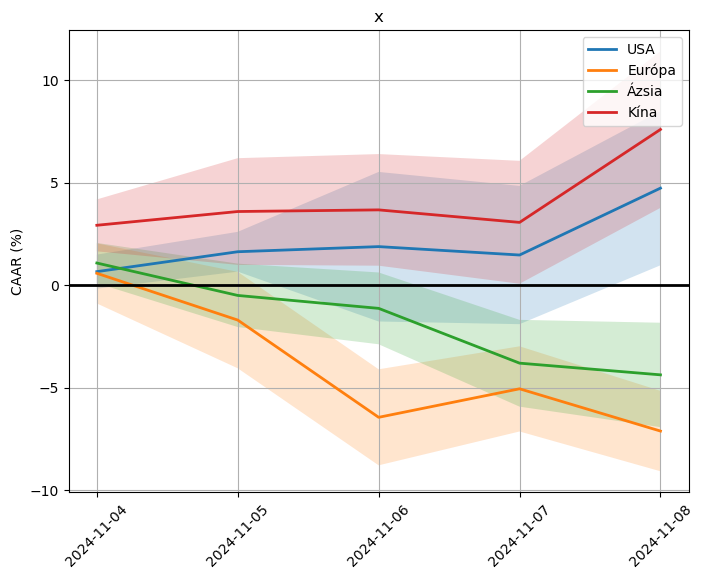

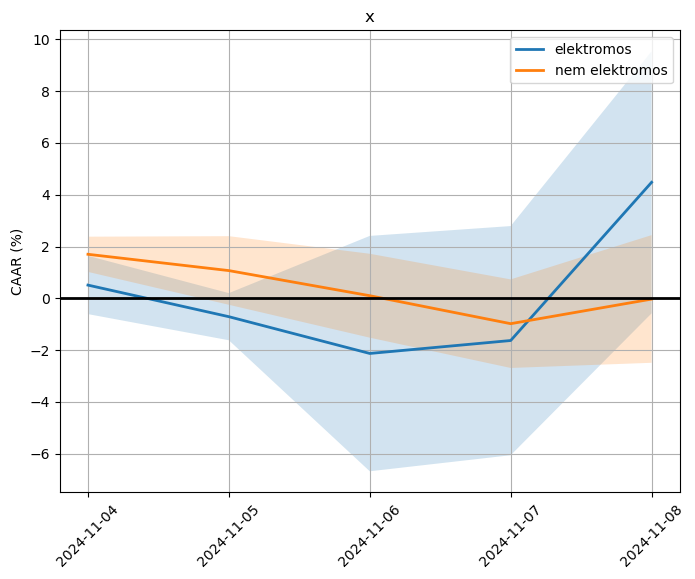

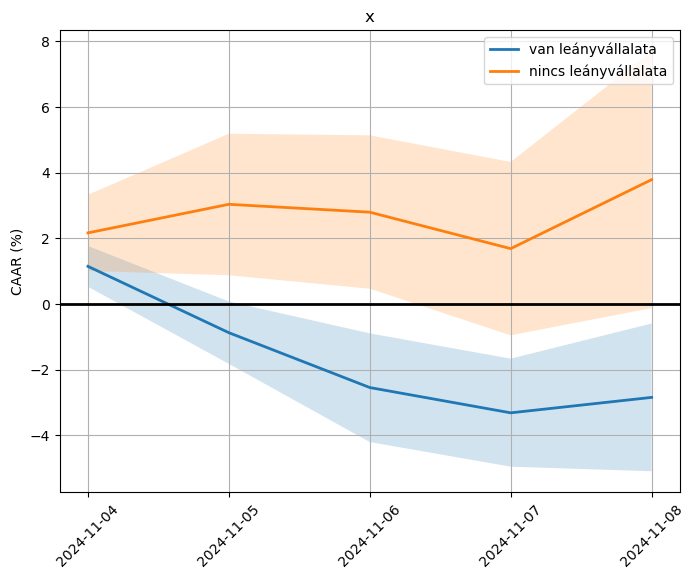

In [20]:
# Function to plot CAR with confidence intervals for specific groups
def plot_car_for_group(group, title, event_dates):
    plt.figure(figsize=(8, 6))
    
    # Filter for the specific event date range
    for cluster in group:
        cluster_data = merged_data[merged_data['Klaszter'] == cluster]
        cluster_data = cluster_data[cluster_data['Date'].isin(event_dates)].sort_values(by='Date')  # Filter and sort
        
        # Drop rows with missing values for CAR, Lower, or Upper
        cluster_data = cluster_data.dropna(subset=['CAR', 'Lower', 'Upper'])
        
        # Plot CAR
        plt.plot(cluster_data['Date'], cluster_data['CAR'], label=f'{cluster}', linewidth=2)
        
        # Plot confidence interval
        plt.fill_between(
            cluster_data['Date'],
            cluster_data['Lower'],
            cluster_data['Upper'],
            alpha=0.2,
            #label=f'{cluster} - 95%-os konfidencia intervallum'
        )
        
    plt.xticks(event_dates, labels=[date.strftime('%Y-%m-%d') for date in event_dates], rotation=45)
    
    plt.ylabel('CAAR (%)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.axhline(y=0, color='black', linewidth=2)
    plt.show()

# Define clusters for each group
regions = ['USA', 'Európa', 'Ázsia', 'Kína']
ev_status = ['elektromos', 'nem elektromos']
us_subsidiary_status = ['van leányvállalata', 'nincs leányvállalata']

# Define event dates manually
event_dates_1 = pd.to_datetime(['2024-02-02', '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08'])
event_dates_2 = pd.to_datetime(['2024-11-22', '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-28'])
event_dates_3 = pd.to_datetime(['2024-11-04', '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08'])

# Plot for Regions around Event 1
plot_car_for_group(regions, 'x', event_dates_3)

# Plot for EV Status around Event 2
plot_car_for_group(ev_status, 'x', event_dates_3)

# Plot for US Subsidiaries around Event 3
plot_car_for_group(us_subsidiary_status, 'x', event_dates_3)